# Distribution of requested fields

The goal of this notebook is to examine the spatial distribution of all sky regions requested for all science cases, cummulatively over all filters. 

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
import config_utils
import survey_footprints
import regions
import healpy as hp
from mw_plot import MWSkyMap, MWSkyMapBokeh
from astropy_healpix import HEALPix
from astropy import units as u
from astropy.coordinates import Galactic, TETE, SkyCoord, ICRS
from astropy.table import Table, Column
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
from os import path
%matplotlib inline


# Configure path to local repository
root_dir = '/Users/rstreet/software/rgps'

## Set up

First load the general simulation parameters:

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

Now load the set of science cases and their configurations:

In [15]:
science_cases = config_utils.read_config(path.join(root_dir, 'config', 'rgps_science_cases.json'))

In [16]:
science_categories = []
for author, info in science_cases.items():
    if info['ready_for_use'] and info['category'] not in science_categories:
        science_categories.append(info['category'])
science_categories

['wide_area',
 'SFR',
 'solar_system',
 'high_cadence',
 'globular_clusters',
 'molecular_clouds',
 'AGN',
 'open_clusters',
 'variable_stars',
 'galactic_center',
 'keyholes',
 'stellar_spectra',
 'YSO',
 'GW']

The regions of sky requested by each science case for all of these categories have been pre-converted into HEALpixel maps to save having to recompute them.  These are stored by category to keep memory requirements and file sizes manageable, so we need to load them separately.

## Map of all requested regions 

It is useful to create a map of all regions requested for all categories and science cases, combining the regions requested in different filters.  This will help us to identify the most popular, and therefore most scientifically valuable, areas.

In [28]:
# Combine all regions for each category into a single CelestialRegion map
category_regions = {}
for category in science_categories: 

    # Load the regions requested for the set of science cases under this category
    science_regions = regions.load_regions_from_file(sim_config,
                                path.join(root_dir, 'region_data', 'rgps_science_regions_' + category + '.json'))

    # Build a list of all regions, combining all optics
    region_list = []
    region_names = []
    for author, params in science_regions.items():
        for optic in sim_config['OPTICAL_COMPONENTS']:

            # Do not duplicate a region if an author has requested it for multiple filters
            if optic in params.keys():
                for r in params[optic]:
                    if r.name not in region_names:
                        region_list.append(r)
                        region_names.append(r.name)
                        
    if len(region_list) > 0:
        r_merge = regions.combine_regions(region_list)
        r_merge.optic = 'ALL'
        r_merge.label = category

        category_regions[category] = r_merge
    else:
        category_regions[category] = None
category_regions

{'wide_area': <regions.CelestialRegion at 0x13a50cb50>,
 'SFR': <regions.CelestialRegion at 0x13a3f3790>,
 'solar_system': <regions.CelestialRegion at 0x168f69f10>,
 'high_cadence': <regions.CelestialRegion at 0x13a065ed0>,
 'globular_clusters': <regions.CelestialRegion at 0x13a678810>,
 'molecular_clouds': <regions.CelestialRegion at 0x168be79d0>,
 'AGN': <regions.CelestialRegion at 0x10788e6d0>,
 'open_clusters': <regions.CelestialRegion at 0x13a227ad0>,
 'variable_stars': <regions.CelestialRegion at 0x12d4306d0>,
 'galactic_center': <regions.CelestialRegion at 0x11854c450>,
 'keyholes': <regions.CelestialRegion at 0x129b57c10>,
 'stellar_spectra': <regions.CelestialRegion at 0x107f0b2d0>,
 'YSO': <regions.CelestialRegion at 0x11843ee10>,
 'GW': <regions.CelestialRegion at 0x118735c50>}

In [29]:
# Combine all regions from all categories to create the map of all requested regions 
region_list = [r for cat, r in category_regions.items()]
combined_region = regions.combine_regions(region_list)

In [31]:
print(combined_region.region_map[combined_region.pixels].max())

66.0


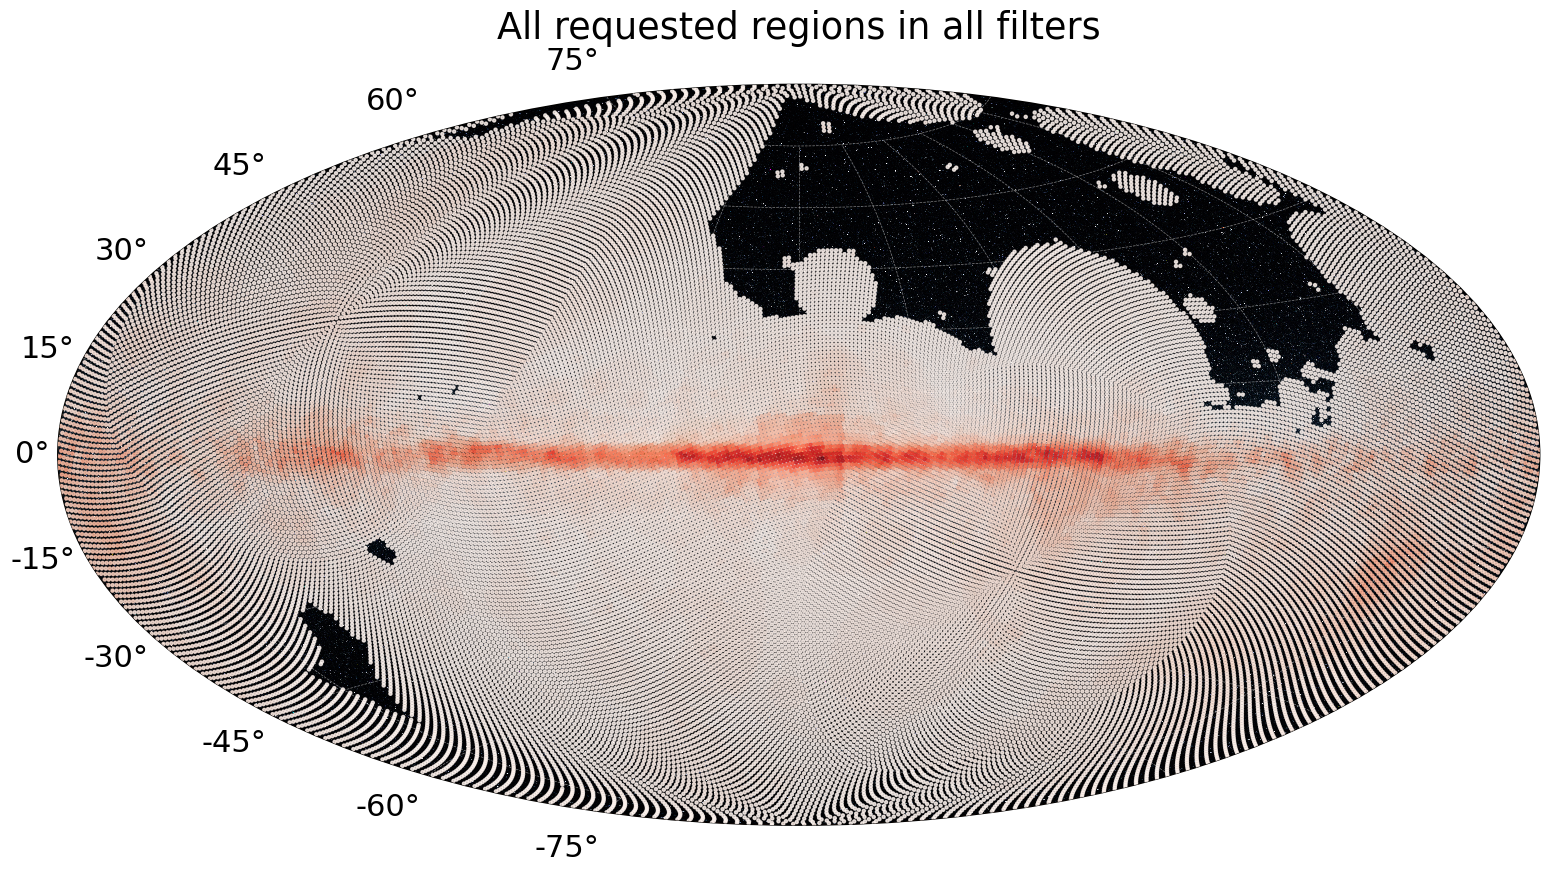

In [32]:
# Plot the combined map for inspection
mw1 = MWSkyMap(projection='aitoff', grayscale=False, grid='galactic', background='infrared', figsize=(16, 10))
mw1.title = 'All requested regions in all filters'
s = combined_region.pixels_to_skycoords()
mw1.scatter(s.ra.deg * u.deg, s.dec.deg * u.deg, c=combined_region.region_map[combined_region.pixels], cmap='Reds', s=5, alpha=0.8)
plt.rcParams.update({'font.size': 22})

plt.tight_layout()
plt.savefig(path.join(root_dir, 'survey_maps', 'all_requested_regions_map.png'))

## Distribution in Galactic Longitude

The distribution of requested pointings as a function of galactic longitude is of interest to help to identify regions in the Plane that are of interest for multiple science goals. 

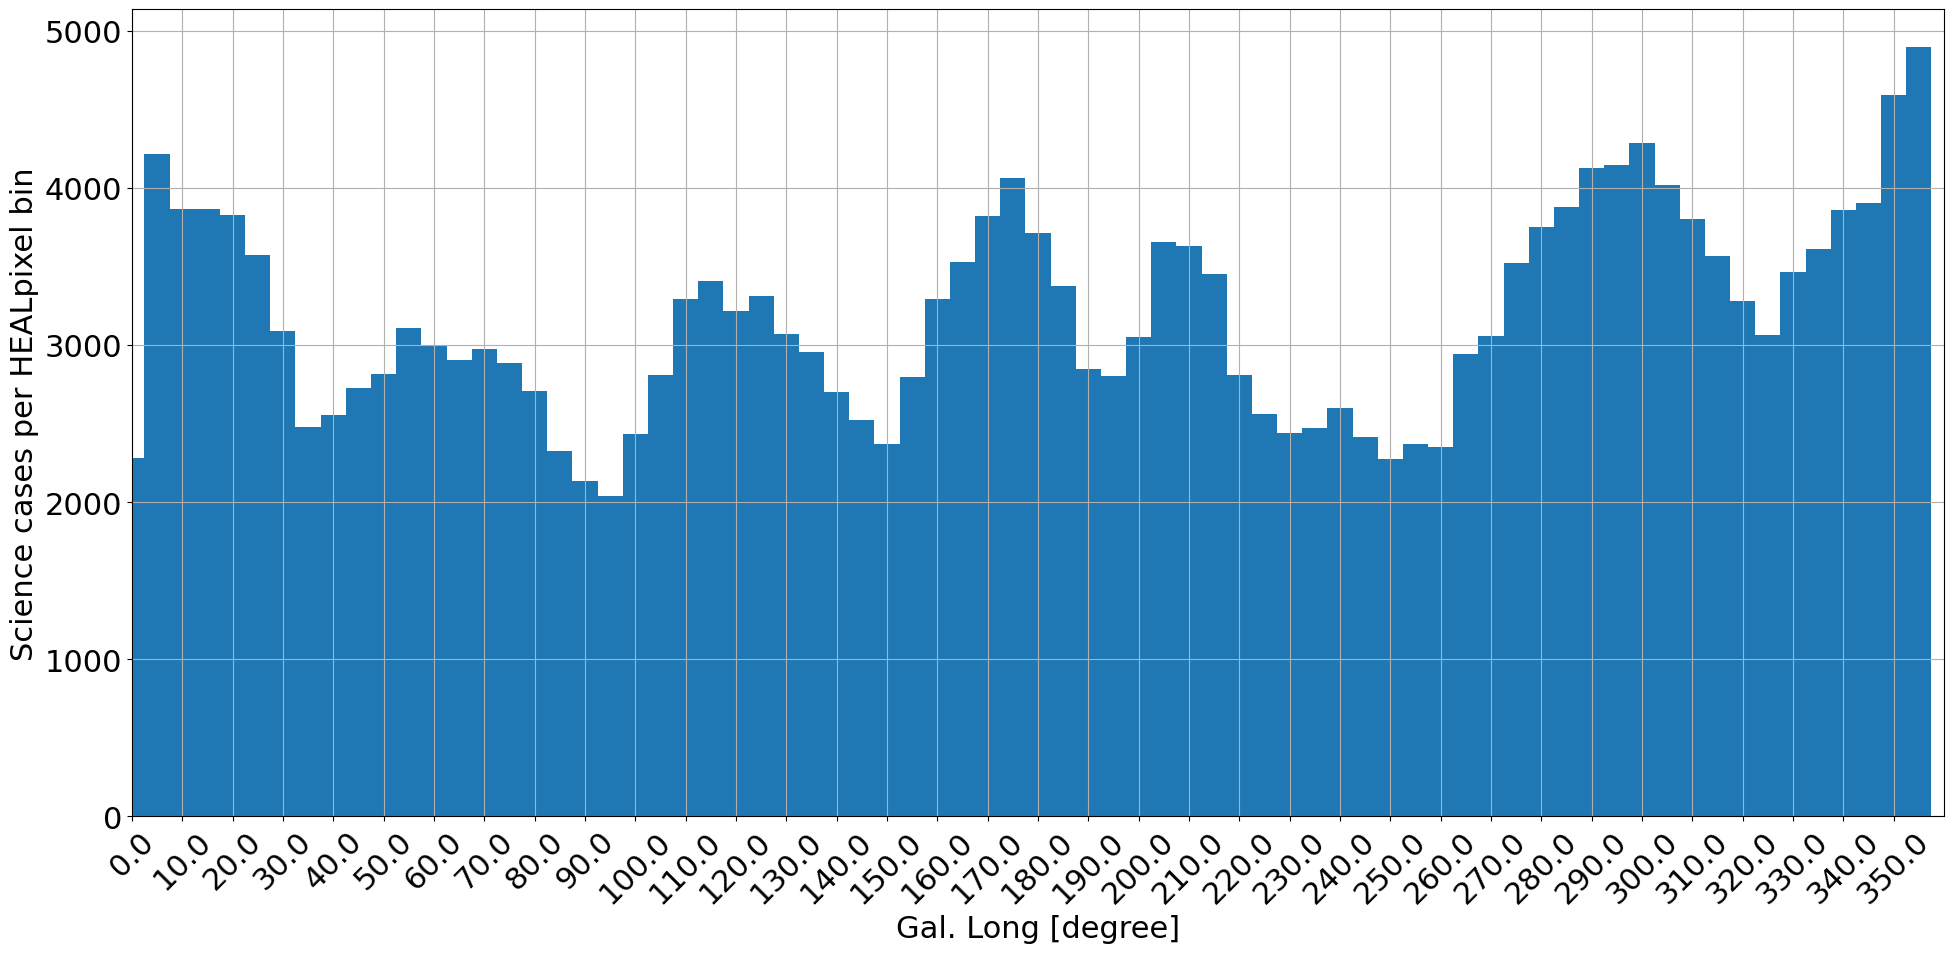

In [75]:
# Identify HEALpixels requested by >1 science case 
idx = np.where(combined_region.region_map > 1.0)[0]
map_values = combined_region.region_map[idx]

# Convert HEALpixels to SkyCoord in galactic coordinates
hp = HEALPix(nside=sim_config['NSIDE'], order='ring', frame='icrs')
coords = hp.healpix_to_skycoord(idx)
coords = coords.transform_to('galactic') 
lvalues = coords.l.deg 

# Bin the science case counts per pixel across the range of gal long
lstep = 5.0

lrange = np.arange(0.0, 360.0, lstep)
case_counts = []
for i,l in enumerate(lrange):
    lmin = l - lstep/2.0
    lmax = l + lstep/2.0
    jdx1 = np.where(lvalues >= lmin)[0]
    jdx2 = np.where(lvalues < lmax)[0]
    jdx = list(set(jdx1).intersection(set(jdx2)))
    case_counts.append(map_values[jdx].sum())
    
# Plot histogram
fig, axs = plt.subplots(1, 1, figsize=(20,10), tight_layout=True)
axs.bar(lrange, case_counts, width=lstep, align='center')
xticks = np.arange(lrange.min(), lrange.max(), 10.0)
xlabels = [str(round(x,0)) for x in xticks]
axs.set_xticks(xticks, xlabels, rotation=45.0)
axs.set_xlim(0.0, 360.0)
axs.grid()
axs.set_xlabel('Gal. Long [degree]')
axs.set_ylabel('Science cases per HEALpixel bin')
plt.savefig(path.join(root_dir, 'survey_maps', 'histogram_science_per_gallong.png'))